In [1]:
# Predictive Maintenance: RUL Prediction using an LSTM Model

# This notebook implements a Long Short-Term Memory (LSTM) network to predict the Remaining Useful Life (RUL) of aircraft turbofan engines. The model is trained on the combined data from all four NASA C-MAPSS datasets (FD001, FD002, FD003, and FD004) to create a single, generalized model.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data Loading and Preprocessing

Here, we load all four training and test datasets. We combine them into single dataframes and calculate the RUL (Remaining Useful Life) for each. The RUL is defined as the number of cycles remaining until failure.

In [3]:
# Define column names for the dataset
columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]

# --- Load and combine all training data ---
train_data_list = []
for i in range(1, 5):
    try:
        df = pd.read_csv(f'train_FD00{i}.txt', sep=" ", header=None)
        df.drop(columns=[26, 27], inplace=True)
        df.columns = columns
        df['dataset'] = f'FD00{i}'
        train_data_list.append(df)
    except FileNotFoundError:
        print(f"Warning: train_FD00{i}.txt not found. Skipping.")
        continue
train_data = pd.concat(train_data_list, ignore_index=True)

# --- Load and combine all test data ---
test_data_list = []
for i in range(1, 5):
    try:
        df = pd.read_csv(f'test_FD00{i}.txt', sep=" ", header=None)
        df.drop(columns=[26, 27], inplace=True)
        df.columns = columns
        df['dataset'] = f'FD00{i}'
        test_data_list.append(df)
    except FileNotFoundError:
        print(f"Warning: test_FD00{i}.txt not found. Skipping.")
        continue
test_data = pd.concat(test_data_list, ignore_index=True)

# --- Load and combine all RUL ground truth data ---
truth_data_map = {}
for i in range(1, 5):
    try:
        df = pd.read_csv(f'RUL_FD00{i}.txt', header=None)
        for unit, rul in enumerate(df[0], 1):
            truth_data_map[(f'FD00{i}', unit)] = rul
    except FileNotFoundError:
        print(f"Warning: RUL_FD00{i}.txt not found. Skipping.")
        continue

# --- Calculate Life Ratio ---

# For training data: life_ratio = current_cycle / total_cycles
total_cycles_train = train_data.groupby(['dataset', 'unit_number'])['time_in_cycles'].transform('max')
train_data['life_ratio'] = train_data['time_in_cycles'] / total_cycles_train

# For test data, find the total real life of the engine
test_data['true_RUL'] = test_data.apply(lambda row: truth_data_map.get((row['dataset'], row['unit_number']), 0), axis=1)
max_cycles_test = test_data.groupby(['dataset', 'unit_number'])['time_in_cycles'].transform('max')
total_cycles_test = max_cycles_test + test_data['true_RUL']
test_data['life_ratio'] = test_data['time_in_cycles'] / total_cycles_test

print("Data loaded. Target variable is 'life_ratio'.")

Data loaded. Target variable is 'life_ratio'.


### Feature Scaling

We scale the sensor features to have a mean of 0 and a standard deviation of 1. This helps the model train more effectively. The scaler is fitted **only** on the training data to prevent data leakage.

In [4]:
# Identify columns that are not useful for prediction
features_to_drop = ['setting_1', 'setting_2', 'TRA', 'T2', 'P2', 'epr', 'Nf_dmd', 'PCNfR_dmd', 'farB', 'htBleed']
train_data.drop(columns=features_to_drop, inplace=True)
test_data.drop(columns=features_to_drop, inplace=True)

# Identify feature columns to be scaled
feature_cols = [col for col in train_data.columns if col not in ['unit_number', 'time_in_cycles', 'life_ratio', 'dataset', 'true_RUL']]

# Scale the features
scaler = StandardScaler()
train_data[feature_cols] = scaler.fit_transform(train_data[feature_cols])
test_data[feature_cols] = scaler.transform(test_data[feature_cols])

print("Features have been scaled.")

Features have been scaled.


### Create Sequences for LSTM

LSTMs require input data to be shaped as sequences of a fixed length. This function creates overlapping windows of data. For each window of sensor readings, the label is the RUL at the very last time step of that window.

In [5]:
def create_sequences(input_data, sequence_length, features):
    sequences = []
    labels = []
    for _, group in input_data.groupby(['dataset', 'unit_number']):
        feature_vals = group[features].values
        ratio_vals = group['life_ratio'].values
        for i in range(len(feature_vals) - sequence_length + 1):
            sequences.append(feature_vals[i:i+sequence_length])
            labels.append(ratio_vals[i+sequence_length-1])
    return np.array(sequences), np.array(labels)

# Define sequence length
SEQUENCE_LENGTH = 50

# Create initial training sequences
X_initial_train, y_initial_train = create_sequences(train_data, SEQUENCE_LENGTH, feature_cols)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_initial_train, y_initial_train, test_size=0.20, random_state=42
)

# Create the final, unseen test set
X_test, y_test = create_sequences(test_data, SEQUENCE_LENGTH, feature_cols)

print(f"Training sequences: {X_train.shape}")
print(f"Validation sequences: {X_val.shape}")
print(f"Test sequences: {X_test.shape}")

Training sequences: (100494, 50, 14)
Validation sequences: (25124, 50, 14)
Test sequences: (70972, 50, 14)


### PyTorch Dataset and DataLoader

We create a custom PyTorch `Dataset` to handle our sequence data and a `DataLoader` to efficiently feed batches of data to the model during training.

In [6]:
class RULDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx].unsqueeze(-1)

# Create datasets for all three splits
train_dataset = RULDataset(X_train, y_train)
val_dataset = RULDataset(X_val, y_val)
test_dataset = RULDataset(X_test, y_test)

# Create DataLoaders for all three splits
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

print("DataLoaders for training, validation, and testing created.")

DataLoaders for training, validation, and testing created.


### Define the LSTM Model Architecture

In [7]:
class CNN_LSTMRULModel(nn.Module):
    def __init__(self, input_size, cnn_out_channels, kernel_size, hidden_size, num_layers, dropout_prob):
        super(CNN_LSTMRULModel, self).__init__()
        
        self.cnn = nn.Conv1d(in_channels=input_size, out_channels=cnn_out_channels, kernel_size=kernel_size, padding='same')
        self.relu_cnn = nn.ReLU()
        
        self.lstm = nn.LSTM(input_size=cnn_out_channels, hidden_size=hidden_size, num_layers=num_layers, 
                              batch_first=True, bidirectional=True, dropout=dropout_prob if num_layers > 1 else 0)
        
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.relu_fc = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Permute for Conv1d: (batch, features, sequence_length)
        x = x.permute(0, 2, 1)
        cnn_out = self.relu_cnn(self.cnn(x))
        
        # Permute back for LSTM: (batch, sequence_length, features)
        lstm_in = cnn_out.permute(0, 2, 1)
        lstm_out, _ = self.lstm(lstm_in)
        
        # Pass to fully connected layers
        out = self.relu_fc(self.fc1(lstm_out[:, -1, :]))
        prediction = self.fc2(self.dropout(out))
        
        return prediction

print("CNN-LSTM Hybrid Model defined.")

CNN-LSTM Hybrid Model defined.


### Model Training

We set up the training environment, define hyperparameters, and train the model. After each epoch, we evaluate the model on the test set and save the version with the best (lowest) RMSE.

In [8]:
# Set device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model Hyperparameters
INPUT_SIZE = X_train.shape[2]
CNN_OUT_CHANNELS = 32
KERNEL_SIZE = 5
HIDDEN_SIZE = 128
NUM_LAYERS = 2
DROPOUT_PROB = 0.5
LEARNING_RATE = 0.001
EPOCHS = 30

model = CNN_LSTMRULModel(
    input_size=INPUT_SIZE, cnn_out_channels=CNN_OUT_CHANNELS, kernel_size=KERNEL_SIZE,
    hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, dropout_prob=DROPOUT_PROB
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Starting model training...")
best_val_rmse = float('inf')

for epoch in range(EPOCHS):
    # --- Training Phase ---
    model.train()
    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # --- Validation Phase ---
    model.eval()
    val_preds = []
    with torch.no_grad():
        for sequences, val_labels in val_loader:
            sequences = sequences.to(device)
            outputs = model(sequences)
            val_preds.append(outputs.cpu().numpy())
            
    val_preds = np.concatenate(val_preds).flatten()
    val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    
    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.6f}, Validation RMSE: {val_rmse:.6f}')
    
    # Save the best model based on validation performance
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        torch.save(model.state_dict(), 'best_model_validated.pth')
        print(f'New best model saved with Validation RMSE: {best_val_rmse:.6f}')

print("\nTraining finished.")

Using device: cuda
Starting model training...
Epoch [1/30], Train Loss: 0.025366, Validation RMSE: 0.146646
New best model saved with Validation RMSE: 0.146646
Epoch [2/30], Train Loss: 0.027290, Validation RMSE: 0.139352
New best model saved with Validation RMSE: 0.139352
Epoch [3/30], Train Loss: 0.024681, Validation RMSE: 0.137592
New best model saved with Validation RMSE: 0.137592
Epoch [4/30], Train Loss: 0.021197, Validation RMSE: 0.130340
New best model saved with Validation RMSE: 0.130340
Epoch [5/30], Train Loss: 0.019923, Validation RMSE: 0.125293
New best model saved with Validation RMSE: 0.125293
Epoch [6/30], Train Loss: 0.019611, Validation RMSE: 0.123366
New best model saved with Validation RMSE: 0.123366
Epoch [7/30], Train Loss: 0.014892, Validation RMSE: 0.123098
New best model saved with Validation RMSE: 0.123098
Epoch [8/30], Train Loss: 0.015014, Validation RMSE: 0.106955
New best model saved with Validation RMSE: 0.106955
Epoch [9/30], Train Loss: 0.014231, Valida

### Final Model Evaluation

We load the best-performing model and run a final evaluation to calculate all the key performance metrics.

In [9]:
# Load the best model identified during validation
model.load_state_dict(torch.load('best_model_validated.pth'))
model.to(device)
model.eval()

# Generate predictions on the unseen test set
y_pred_list = []
with torch.no_grad():
    for sequences, test_labels in test_loader:
        sequences = sequences.to(device)
        y_pred_list.append(model(sequences).cpu().numpy())

y_pred = np.concatenate(y_pred_list).flatten()

# --- Calculate and Print Metrics ---
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Custom accuracy based on a 10% tolerance of total life
absolute_tolerance = 0.10 
custom_accuracy = np.mean(np.abs(y_pred - y_test) < absolute_tolerance) * 100

print(f"--- Final Model Performance on Unseen Test Data ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f} (Avg. error is ~{rmse*100:.2f}% of total life)")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R-squared (R²) Score: {r2:.4f}")
print(f"Accuracy (within ±{absolute_tolerance*100:.0f}% of total life): {custom_accuracy:.2f}%")

C:\Users\rsree\AppData\Local\Temp\ipykernel_4060\1855865245.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_validated.pth'))

--- Final Model Performance on Unseen Test Data ---
Root Mean Squared Error (RMSE): 0.107849 (Avg. error is ~10.78% of total life)
Mean Absolute Error (MAE): 0.081991
R-squared (R²) Score: 0.6872
Accuracy (within ±10% of total life): 67.67%


### Visualize Results

Finally, we plot the true RUL against the predicted RUL for the last 200 data points in the test set to visually inspect the model's performance.

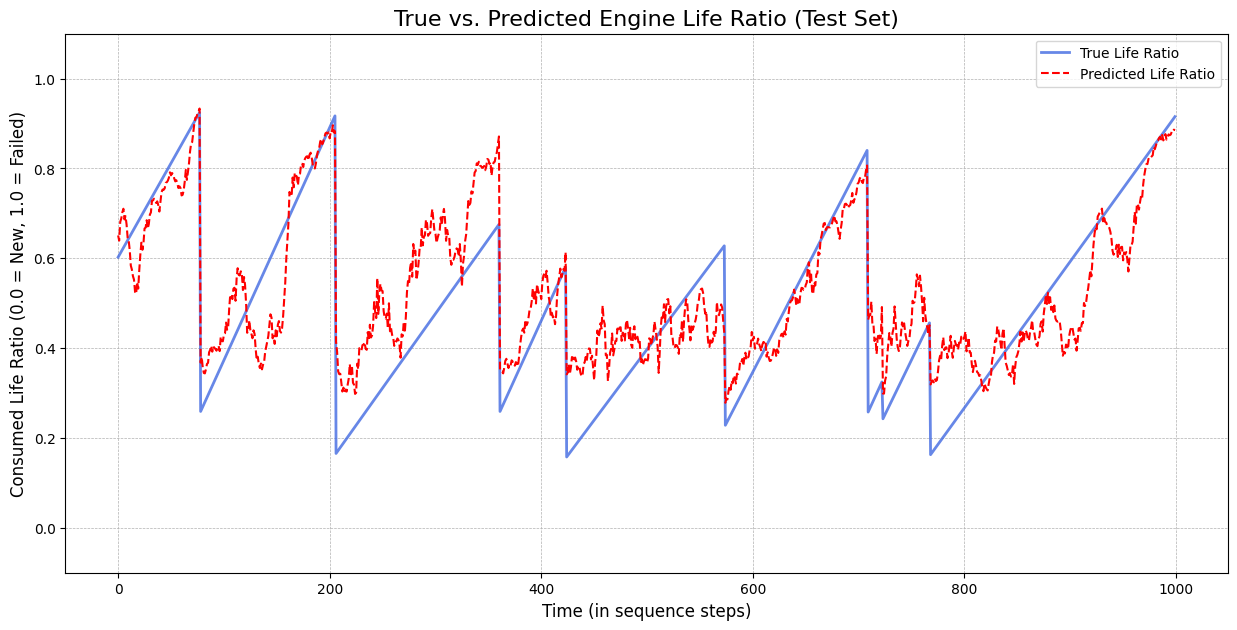

In [10]:
plt.figure(figsize=(15, 7))

# Plot a sample of the test set for clarity
num_points_to_plot = 1000

plt.plot(y_test[-num_points_to_plot:], label='True Life Ratio', color='royalblue', alpha=0.8, linewidth=2)
plt.plot(y_pred[-num_points_to_plot:], label='Predicted Life Ratio', color='red', linestyle='--')

plt.title('True vs. Predicted Engine Life Ratio (Test Set)', fontsize=16)
plt.xlabel('Time (in sequence steps)', fontsize=12)
plt.ylabel('Consumed Life Ratio (0.0 = New, 1.0 = Failed)', fontsize=12)
plt.ylim(-0.1, 1.1)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()